In [1]:
!pip install sentence_transformers
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 33.4 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 6.6 MB 41.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=e14aabea53e0077146613d57df52540e316cb58f2f0c24fa8328468d8653d4b3
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 4.5 MB

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Anomaly\ detection

/content/drive/MyDrive/Anomaly detection


In [4]:
import torch
import pandas as pd
from datetime import datetime
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData
import torch
from torch_geometric.nn import MetaPath2Vec

##Get Data

In [5]:
database_path = "data_out_head_10000.csv"
fake="fake_data.csv"
print('get data')
real = pd.read_csv(database_path).fillna("")
real['latitude']=real['Location'].apply(lambda x : float(x.split(',')[0][1:]))
real['longitude']=real['Location'].apply(lambda x : float(x.split(',')[1][:-1]))
print(real.shape)
fake = pd.read_csv(fake).fillna("")
fake['latitude']=fake['Location'].apply(lambda x : float(x.split(',')[0][1:]))
fake['longitude']=fake['Location'].apply(lambda x : float(x.split(',')[1][:-1]))
dataframe=pd.concat([real,fake])
print(dataframe.shape)

get data
(10000, 19)
(10205, 19)


##Graph

In [6]:
def load_node_csv(dataframe, index_col, encoders=None):
    df = dataframe.set_index(index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    # if list_col is not None:
    #    for col in list_col:
    #        xs = torch.tensor(df[col].values)
    #        x = torch.cat([x, xs], dim=1)
    if encoders is not None:
        xs=[]
        for col, encoder in encoders.items():
          print(col)
          #xs = [encoder(df[col]) for col, encoder in encoders.items()]
          var=encoder(df.iloc[0:100][col])
          for batch in range(1,int(len(df)/100)):
            var=torch.cat((var, encoder(df.iloc[batch*100:min((batch+1)*100,len(df))][col])), 1) 
          xs.append(var)
        x = torch.cat(xs, dim=-1)

    return x, mapping



class SequenceEncoder(object):
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
          
        return x.cpu()


class GenresEncoder(object):
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        genres = set(g for col in df.values for g in col.split(self.sep))
        mapping = {genre: i for i, genre in enumerate(genres)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for genre in col.split(self.sep):
                x[i, mapping[genre]] = 1
        return x


class IdentityEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)

class DateTimeEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(pd.to_datetime(df, infer_datetime_format=True).apply(lambda x: datetime.timestamp(x)).values).view(-1, 1).to(self.dtype)


def load_edge_csv(dataframe, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  encoders=None):
    df = dataframe

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    edge_attr = None
    if encoders is not None:
        edge_attrs=[]
        for col, encoder in encoders.items():
          var_edge=encoder(df.iloc[0:100][col])
          for batch in range(1,int(len(df)/100)):
            var_edge=torch.cat((var_edge,encoder(df.iloc[batch*100:min((batch+1)*100,len(df))][col])),1)
          edge_attrs.append(var_edge)
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [7]:
def generate_graph(dataframe):
    data = HeteroData()

    # Loading nodes into graph
    data['customer'].x, customer_mapping = load_node_csv(dataframe, "Customer_id",customer_encodings)
    data['product'].x, product_mapping = load_node_csv(dataframe, "product_id", product_encodings)
    _, user_mapping = load_node_csv(dataframe, "user_id")
    data['user'].num_nodes = len(user_mapping)  # user has no features

    print(data)

    # Loading edges into graph
    data['customer', 'has', 'user'].edge_index, _ = load_edge_csv(
        dataframe,
        src_index_col='Customer_id',
        src_mapping=customer_mapping,
        dst_index_col='user_id',
        dst_mapping=user_mapping,
    )

    data['product', 'license','customer'].edge_index, data[
        'product', 'license','customer'].edge_attr = load_edge_csv(
        dataframe,
        src_index_col='product_id',
        src_mapping=product_mapping,
        dst_index_col='Customer_id',
        dst_mapping=customer_mapping,
        encoders=licence_encodings
    )
    data['user', 'opened_session', 'product'].edge_index, data[
        'user', 'opened_session', 'product'].edge_attr = load_edge_csv(
        dataframe,
        src_index_col='user_id',
        src_mapping=user_mapping,
        dst_index_col='product_id',
        dst_mapping=product_mapping,
        encoders=session_encodings
    )
    return data


def display_csv(path):
    df = pd.read_csv(path)
    print(df.head())

In [8]:
customer_encodings = {"latitude": IdentityEncoder(dtype=torch.long),"longitude":IdentityEncoder(dtype=torch.long)}
product_encodings = {  # "brand": SequenceEncoder(),
        "price": IdentityEncoder(dtype=torch.long),
        "category_id": IdentityEncoder(dtype=torch.long)
}
session_encodings = {
        "Session_id": SequenceEncoder(),
        "Session_start_datetime": DateTimeEncoder(dtype=torch.long),
        "Session_end_datetime": DateTimeEncoder(dtype=torch.long),
        "user_id": IdentityEncoder(dtype=torch.long)
}
licence_encodings = {
        "License_id": IdentityEncoder(dtype=torch.long),
        "License_start_date": DateTimeEncoder(dtype=torch.long),
        "License_end_date": DateTimeEncoder(dtype=torch.long),
}

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [9]:
data = generate_graph(dataframe)

latitude
longitude
price
category_id
HeteroData(
  customer={ x=[100, 204] },
  product={ x=[100, 204] },
  user={ num_nodes=5641 }
)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
data

HeteroData(
  customer={ x=[100, 204] },
  product={ x=[100, 204] },
  user={ num_nodes=5641 },
  (customer, has, user)={ edge_index=[2, 10205] },
  (product, license, customer)={
    edge_index=[2, 10205],
    edge_attr=[100, 306]
  },
  (user, opened_session, product)={
    edge_index=[2, 10205],
    edge_attr=[100, 39474]
  }
)

In [11]:
data.edge_index_dict

{('customer',
  'has',
  'user'): tensor([[   0,    1,    2,  ..., 5336, 5337, 5338],
         [   0,    1,    2,  ..., 5638, 5639, 5640]]),
 ('product',
  'license',
  'customer'): tensor([[   0,    0,    0,  ...,  599,  600,  601],
         [   0,    1,    2,  ..., 5336, 5337, 5338]]),
 ('user',
  'opened_session',
  'product'): tensor([[   0,    1,    2,  ..., 5638, 5639, 5640],
         [   0,    0,    0,  ...,  599,  600,  601]])}

##Embedding

In [12]:
metapath = [
    ('customer', 'has', 'user'),
    ('user', 'opened_session', 'product'),
    ('product', 'license','customer')
  
]

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,
                     metapath=metapath, walk_length=50, context_size=7,
                     walks_per_node=2, num_negative_samples=5,
                     sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
for epoch in range(1, 6):
  train(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
embedding=model('customer')

In [16]:
print(embedding.shape)
embedding

torch.Size([5339, 128])


tensor([[ 0.8094, -1.4841,  1.0982,  ...,  0.9178, -0.7387, -0.5506],
        [-0.1446,  1.7468, -0.2308,  ...,  0.5716, -1.6611, -0.3964],
        [ 0.5136, -0.6855,  2.3195,  ...,  1.2281, -0.0271, -0.0518],
        ...,
        [ 0.3812, -1.2455,  0.5520,  ..., -0.0517,  1.3525, -0.0974],
        [ 0.2623,  0.6678, -0.0578,  ...,  0.0846, -2.0412, -0.8853],
        [ 0.7287, -0.0573,  1.0723,  ...,  2.1552, -1.1356,  0.4966]],
       grad_fn=<SliceBackward0>)

In [17]:
dic={}
for k,v in zip(dataframe['Customer_id'].unique().tolist(),embedding.cpu().detach().numpy()):
  dic[k]=v

In [18]:
print(len(dic))

5339


##Clustering

###K-Means

###Elbow method : get the optimal number of clusters

In [ ]:
from sklearn.cluster import KMeans
import numpy 
# function returns WSS score for k values from 1 to kmax

kmax=30
sse = []
for k in range(1,kmax+1):
  print(k)
  kmeans = KMeans(n_clusters = k).fit(embedding.cpu().detach().numpy())
  centroids = kmeans.cluster_centers_
  pred_clusters = kmeans.predict(embedding.cpu().detach().numpy())
  curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
  for i in range(len(embedding)):
    curr_center = centroids[pred_clusters[i]]
    curr_sse += numpy.linalg.norm(embedding.cpu().detach().numpy()[i]-curr_center)
    #for j in range(embedding.shape[1]):
      #curr_sse += (embedding[i, j] - curr_center[j]) ** 2
      
  sse.append(curr_sse)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


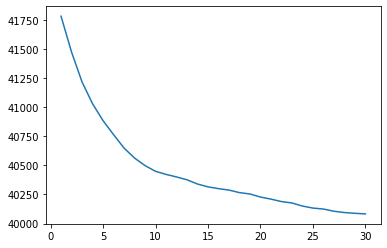

In [ ]:
import matplotlib.pyplot as plt
y=sse
len(y)
x=[k for k in range(1,len(y)+1)]

plt.plot(x,y)
plt.show()

In [39]:
from sklearn.cluster import KMeans
import numpy as np
km = KMeans(n_clusters=13).fit(embedding.cpu().detach().numpy())
centroids = km.cluster_centers_
print(len(centroids))
df=pd.DataFrame()
df['Customer_id']=dic.keys()
df['distance']=[ [] for i in range(len(dic.keys()))]
for i in range (len(embedding)):
  for j in range(len(centroids)):
    df.loc[i,'distance'].append(np.linalg.norm(embedding.cpu().detach().numpy()[i]-centroids[j]))

13


In [ ]:
df

In [40]:
df['inv_variance']=df['distance'].apply(lambda x : 1/np.var(x))
df['nearest_clus']=df['distance'].apply(lambda x :  x.index(np.min(x)))

In [41]:
def second_smallest(numbers):
  m1 = m2 = float('inf')
  for x in numbers:
    if x <= m1:
      m1, m2 = x, m1
    elif x < m2:
      m2 = x
  return m2

In [42]:
df['dis_inter_minimums']=df['distance'].apply(lambda x : np.sqrt((np.min(x)-second_smallest(x))**2))

###Distance between the two minimums to decide

In [43]:
df_inter_dist=df.sort_values(by=['dis_inter_minimums'],ascending=True)
df_inter_dist['rank']=[i for i in range(1,len(df_inter_dist)+1)]

In [44]:
df_inter_dist

,Customer_id,distance,inv_variance,nearest_clus,dis_inter_minimums,rank
619,529898159_653277,"[11.721487, 11.787265, 12.043568, 12.052882, 1...",55.949032,9,0.000362,1
2052,560495797_981797,"[10.999923, 10.922634, 11.044543, 10.969717, 1...",21.361979,12,0.000746,2
3527,429659840_600537,"[12.356452, 12.69401, 12.355536, 12.869881, 12...",29.534434,2,0.000916,3
138,529947371_984868,"[12.834742, 13.177091, 12.522957, 13.04365, 12...",20.080759,6,0.001141,4
3606,441853187_919396,"[10.546648, 10.247239, 10.787083, 10.661812, 1...",29.851144,5,0.001236,5
...,...,...,...,...,...,...
3230,518542185_65274,"[10.41955, 9.176848, 10.507676, 10.509052, 10....",7.870209,1,1.076074,5335
454,612678887_289075,"[10.957358, 11.148346, 10.71216, 10.990154, 10...",6.736383,12,1.108550,5336
4551,600769041_200375,"[11.43905, 11.152389, 11.312206, 11.370911, 11...",7.610557,7,1.125039,5337
66,601412591_446501,"[10.927834, 11.116763, 10.840405, 9.484968, 10...",7.093246,3,1.195861,5338


Text(0.5, 1.0, 'Distributin de la distance entre les deux minimums pour les data réels')

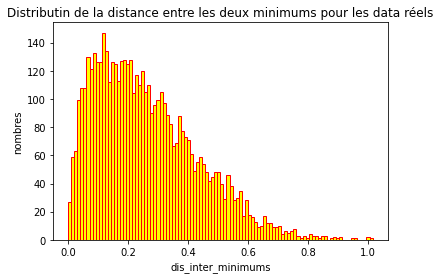

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df[df['Customer_id'].isin(real['Customer_id'].tolist())]['dis_inter_minimums'].tolist()
plt.hist(x, range = (0, np.max(x)), bins = 100, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('dis_inter_minimums')
plt.ylabel('nombres')
plt.title("Distributin de la distance entre les deux minimums pour les data réels")

0.45711660385131836


Text(0.5, 1.0, 'Distributin de la distance entre les deux minimums pour les fake data')

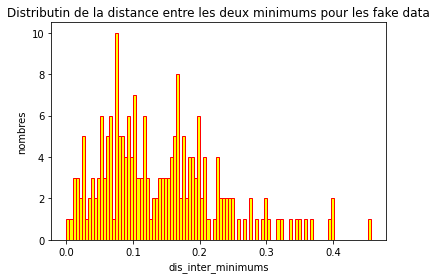

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df[df['Customer_id'].isin(fake['Customer_id'].tolist())]['dis_inter_minimums'].tolist()
print(np.max(x))
plt.hist(x, range = (0, np.max(x)), bins = 100, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('dis_inter_minimums')
plt.ylabel('nombres')
plt.title("Distributin de la distance entre les deux minimums pour les fake data")

4616


Text(0.5, 1.0, 'Rang fake data selon la distance entre les deux minimums')

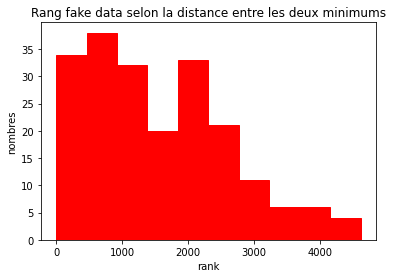

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df_inter_dist[df_inter_dist['Customer_id'].isin(fake['Customer_id'].tolist())]['rank'].tolist()
print(np.max(x))
plt.hist(x, range = (0, np.max(x)), bins = 10, color = 'red',
            edgecolor = 'red')
plt.xlabel('rank')
plt.ylabel('nombres')
plt.title("Rang fake data selon la distance entre les deux minimums")

###How many fake Customers we have in the first 2500 lignes

In [46]:
test_mimimum=df_inter_dist.head(1500)
anomalies_in_test1=test_mimimum[test_mimimum['Customer_id'].isin(fake['Customer_id'].tolist())]['Customer_id']
len(anomalies_in_test1)

57

###The inverse of the variance to decide

In [48]:
df_var=df.sort_values(by=['inv_variance'],ascending=False)
df_var['rank']=[i for i in range(1,len(df_var)+1)]

In [ ]:
df_var

,Customer_id,distance,inv_variance,nearest_clus,dis_inter_minimums,rank
5256,1936800692,"[10.385518, 10.205178, 10.207689, 10.290624, 1...",226.790103,10,0.015182,1
5274,3764623842,"[9.988474, 10.040764, 10.043493, 10.07072, 10....",145.492417,10,0.040739,2
5232,QvujBcde2uPcaRgLDX,"[10.286985, 10.373861, 10.299966, 10.392344, 1...",125.804062,5,0.104633,3
5329,3050070046,"[10.295115, 10.078254, 10.010064, 10.154455, 1...",105.411846,5,0.106183,4
4881,511308296_300309,"[9.175671, 8.995991, 9.177631, 9.141135, 8.914...",96.727833,4,0.076811,5
...,...,...,...,...,...,...
1040,489888989_239766,"[6.589865, 7.135733, 7.306021, 7.18672, 7.1003...",7.146412,11,0.646484,5335
2078,411866170_993883,"[6.430337, 7.0302863, 6.638497, 6.7710667, 6.6...",6.584577,6,0.370204,5336
1780,404329010_78195,"[7.7538314, 8.061035, 7.966126, 8.004925, 8.05...",6.529069,6,0.621518,5337
1885,542689770_1015859,"[7.717189, 8.082106, 7.996431, 7.9928, 7.69421...",6.449663,6,0.459882,5338


Text(0.5, 1.0, "Distributin de l'inverse de la variance pour les data réels")

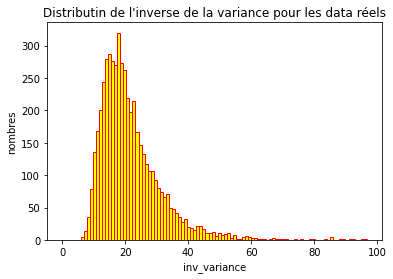

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df[df['Customer_id'].isin(real['Customer_id'].tolist())]['inv_variance'].tolist()
plt.hist(x, range = (0, np.max(x)), bins = 100, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('inv_variance')
plt.ylabel('nombres')
plt.title("Distributin de l'inverse de la variance pour les data réels")

Text(0.5, 1.0, "Distributin de l'inverse de la variance pour les fake data")

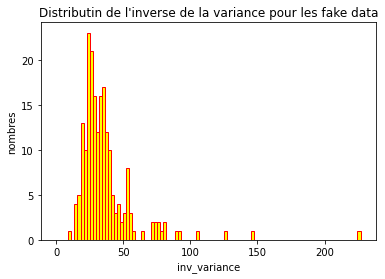

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df[df['Customer_id'].isin(fake['Customer_id'].tolist())]['inv_variance'].tolist()
plt.hist(x, range = (0, np.max(x)), bins = 100, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('inv_variance')
plt.ylabel('nombres')
plt.title("Distributin de l'inverse de la variance pour les fake data")

5057


Text(0.5, 1.0, "Rang fake data selon l'inverse de la variance")

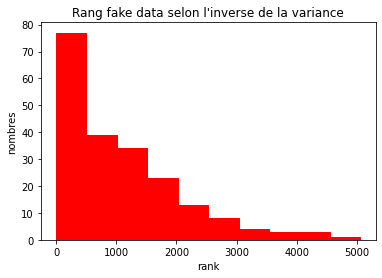

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df_var[df_var['Customer_id'].isin(fake['Customer_id'].tolist())]['rank'].tolist()
print(np.max(x))
plt.hist(x, range = (0, np.max(x)), bins = 10, color = 'red',
            edgecolor = 'red')
plt.xlabel('rank')
plt.ylabel('nombres')
plt.title("Rang fake data selon l'inverse de la variance")

###How many fake Customers we have in the first 2000 lignes

In [49]:
test_variance=df_var.head(2000)
anomalies_in_test2=test_variance[test_variance['Customer_id'].isin(fake['Customer_id'].tolist())]['Customer_id']
print(len(anomalies_in_test2))

79


We fix the number of clusters at 1000

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
km = KMeans(n_clusters=1000).fit(embedding.cpu().detach().numpy())
centroids = km.cluster_centers_
pred_clusters = km.predict(embedding.cpu().detach().numpy())

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['id'] = dic.keys()
cluster_map['cluster'] = pred_clusters

######Anomalies are points attached to one-point-clusters

In [ ]:
df=cluster_map.groupby('cluster').count().reset_index()
anomal_cluster=df[df["id"]==1]['cluster'].tolist()
anomalies=cluster_map[cluster_map['cluster'].isin(anomal_cluster)]['id'].tolist()


In [ ]:
len([i  for i in anomalies if i in fake['Customer_id'].tolist() ])


128

In [19]:
customers=pd.DataFrame()
customers['Customer_id']=dic.keys()

In [20]:
customers['y_actu']= customers['Customer_id'].apply(lambda x : 1 if x in list(fake['Customer_id']) else 0)
customers['y_pred']= customers['Customer_id'].apply(lambda x : 1 if x in list(anomalies) else 0)

In [ ]:
customers

,Customer_id,y_actu,y_pred
0,480374496_65446,0,0
1,552795963_171732,0,0
2,405986628_283400,0,0
3,610461263_109078,0,0
4,530951720_21726,0,0
...,...,...,...
5334,3920966816,1,0
5335,1317090842,1,1
5336,2219104592,1,1
5337,3835109225,1,1


In [ ]:
def sensitivity (customers, fake):
  VP= len(customers.query('y_actu==1 and y_pred==1')['Customer_id'].tolist())
  return VP/fake['Customer_id'].nunique()

In [ ]:
sensitivity (customers, fake)

0.624390243902439

In [ ]:
def specificity(customers, real):
  VN=len(customers.query('y_actu==0 and y_pred==0')['Customer_id'].tolist())
  return VN/real['Customer_id'].nunique()

In [ ]:
specificity(customers, real)

0.864433190494741

In [ ]:
import pandas as pd

y_actu = pd.Series(customers['y_actu'].tolist(), name='Actual')
y_pred = pd.Series(customers['y_pred'].tolist(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

In [ ]:
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [ ]:
df_confusion

Predicted,0,1,All
Actual,,,
0,4438,696,5134
1,77,128,205
All,4515,824,5339


##SVM - One Class

In [ ]:
print("number of real Customer :", real['Customer_id'].nunique())
print("number of fake Customer :", fake['Customer_id'].nunique())

number of real Customer : 5134
number of real Customer : 205


##How to get SVM params

In [51]:
y_train=[1]*real['Customer_id'].nunique()
y_train+=[-1]*fake['Customer_id'].nunique()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
nus = [0.001, 0.01, 0.1, 1]
gammas = [0.001, 0.01, 0.1, 1]
tuned_parameters = {'kernel' : ['rbf', 'poly', 'sigmoid'], 'gamma' : gammas, 'nu': nus}

clf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=10,
                           scoring='%s_macro' % 'precision', return_train_score=True)

clf.fit(embedding.cpu().detach().numpy(), y_train)

resultDf = pd.DataFrame(clf.cv_results_)
print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

    mean_test_score  std_test_score  \
0          0.881845        0.198332   
32         0.880769        0.242308   
44         0.880769        0.242308   
45         0.780769        0.273618   
1          0.779570        0.235764   

                                              params  
0     {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.001}  
32  {'gamma': 0.1, 'kernel': 'sigmoid', 'nu': 0.001}  
44    {'gamma': 1, 'kernel': 'sigmoid', 'nu': 0.001}  
45     {'gamma': 1, 'kernel': 'sigmoid', 'nu': 0.01}  
1      {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.01}  
Best parameters set found on development set:

{'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.001}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Visualisation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


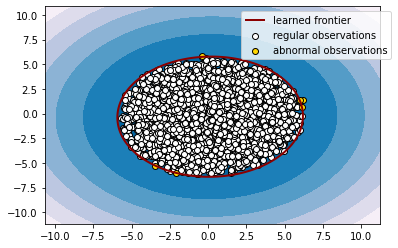

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# load the data

# rescale the data
x_scaled = MinMaxScaler().fit_transform(embedding.cpu().detach().numpy())

# reduce the data to 2 dimensions using t-SNE
x_reduced = TSNE(n_components=2, random_state=0).fit_transform(x_scaled)

# fit the model to the reduced data
svm = OneClassSVM(kernel='rbf', nu=0.001, gamma=1e-03)
svm.fit(x_reduced)

# extract the model predictions
x_predicted = svm.predict(x_reduced)

# define the meshgrid
x_min, x_max = x_reduced[:, 0].min() - 5, x_reduced[:, 0].max() + 5
y_min, y_max = x_reduced[:, 1].min() - 5, x_reduced[:, 1].max() + 5

x_ = np.linspace(x_min, x_max, 500)
y_ = np.linspace(y_min, y_max, 500)

xx, yy = np.meshgrid(x_, y_)

# evaluate the decision function on the meshgrid
z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# plot the decision function and the reduced data
plt.contourf(xx, yy, z, cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
b = plt.scatter(x_reduced[x_predicted == 1, 0], x_reduced[x_predicted == 1, 1], c='white', edgecolors='k')
c = plt.scatter(x_reduced[x_predicted == -1, 0], x_reduced[x_predicted == -1, 1], c='gold', edgecolors='k')
plt.legend([a.collections[0], b, c], ['learned frontier', 'regular observations', 'abnormal observations'], bbox_to_anchor=(1.05, 1))
plt.axis('tight')
plt.show()

###SVM to decide

In [ ]:
from sklearn.svm import OneClassSVM
clf=OneClassSVM(nu= 0.001, kernel="rbf", gamma=0.001)
clf.fit(embedding.cpu().detach().numpy())
result=clf.predict(embedding.cpu().detach().numpy())

In [ ]:
df_svm=pd.DataFrame()
df_svm['Customer_id']=dic.keys()
for i in range (len(embedding)):
    df_svm.loc[i,'distance']= float(clf.decision_function(embedding.cpu().detach().numpy()[i].reshape(1, -1)))

Text(0.5, 1.0, 'Distributin de la distance à la frontière pour les data réels')

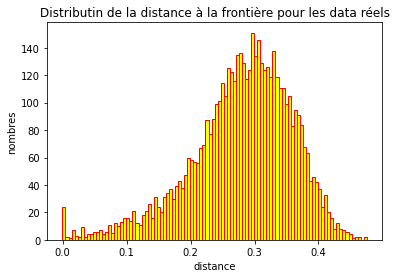

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df_svm[df_svm['Customer_id'].isin(real['Customer_id'].tolist())]['distance'].tolist()
plt.hist(x, range = (np.min(x), np.max(x)), bins = 100, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('distance')
plt.ylabel('nombres')
plt.title("Distributin de la distance à la frontière pour les data réels")

Text(0.5, 1.0, 'Distributin de la distance à la frontière pour les fake data')

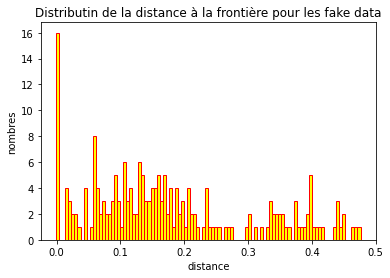

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df_svm[df_svm['Customer_id'].isin(fake['Customer_id'].tolist())]['distance'].tolist()
plt.hist(x, range = (np.min(x), np.max(x)), bins = 100, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('distance')
plt.ylabel('nombres')
plt.title("Distributin de la distance à la frontière pour les fake data")

In [ ]:
df_svm=df_svm.sort_values(by=['distance'],ascending=True)
df_svm['rank']=[i for i in range(1,len(df_svm)+1)]

In [ ]:
df_svm

,Customer_id,distance,rank
5188,TOnzTWjjU7da87KCf7,-0.000526,1
5190,EprZLNf3iNyOAHr7cD,-0.000366,2
5199,uEnjofxHz57J5Mq7oG,-0.000359,3
5292,1593767976,-0.000307,4
1483,465607471_785806,-0.000267,5
...,...,...,...
3092,568080728_323591,0.464755,5335
5212,WKOgH2bjYnMaOIdAGM,0.467838,5336
3982,562013813_466802,0.473584,5337
1534,585731585_992524,0.475500,5338


5339


Text(0.5, 1.0, 'Rang fake data selon distance à la frontière')

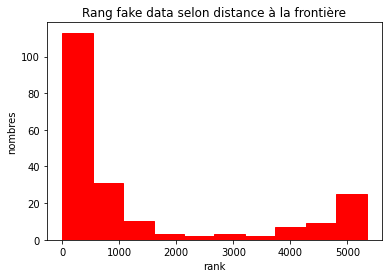

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=df_svm[df_svm['Customer_id'].isin(fake['Customer_id'].tolist())]['rank'].tolist()
print(np.max(x))
plt.hist(x, range = (0, np.max(x)), bins = 10, color = 'red',
            edgecolor = 'red')
plt.xlabel('rank')
plt.ylabel('nombres')
plt.title("Rang fake data selon distance à la frontière")

###How many fake Customers we have in the first 2000 lignes

In [ ]:
tt=df_svm[:1000]
tt[tt['Customer_id'].isin(fake['Customer_id'].tolist())]

,Customer_id,distance,rank
5188,TOnzTWjjU7da87KCf7,-0.000526,1
5190,EprZLNf3iNyOAHr7cD,-0.000366,2
5199,uEnjofxHz57J5Mq7oG,-0.000359,3
5292,1593767976,-0.000307,4
5233,DUFApHz1eshy3YRwM2,-0.000178,6
...,...,...,...
5186,qrsKss7Ada0KOtGyVN,0.201795,911
5263,4988724045,0.204783,949
5314,1313470339,0.206985,973
5253,4514627278,0.208748,996


##GMM

###Get GMM params

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM

tuned_parameters = {'n_components' : [i for i in range (1,10,3)], 'random_state' : [0]}

clf = GridSearchCV(GaussianMixture(), tuned_parameters, cv=10,
                           scoring='%s_macro' % 'precision', return_train_score=True)

clf.fit(embedding.cpu().detach().numpy(), y_train)

resultDf = pd.DataFrame(clf.cv_results_)
print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

   mean_test_score  std_test_score                                  params
1         0.240143        0.029571  {'n_components': 4, 'random_state': 0}
2         0.148008        0.032619  {'n_components': 7, 'random_state': 0}
0         0.000000        0.000000  {'n_components': 1, 'random_state': 0}
Best parameters set found on development set:

{'n_components': 4, 'random_state': 0}


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


### Gmm

In [21]:
import numpy as np
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, random_state=0).fit(embedding.cpu().detach().numpy())

In [22]:
def second_max(numbers):

  new_list = set(numbers)
  new_list.remove(max(new_list))
  return max(new_list)


In [23]:
def cal_proba(l):
  res=1
  for el in l:
    res=res*(1-el)
  return 1-res

In [24]:
customers['GMM_pred_prob']=gm.predict_proba(embedding.cpu().detach().numpy()).tolist()
customers['GMM_pred_prob_max']=customers['GMM_pred_prob'].apply(lambda x : max(x))
customers['GMM_pred_prob_sec_max']=customers['GMM_pred_prob'].apply(lambda x : second_max(x))
customers['GMM_proba_diff']=customers['GMM_pred_prob'].apply(lambda x : max(x)-second_max(x))
customers['GMM_anomaly_proba']=customers['GMM_pred_prob'].apply(lambda x : cal_proba(x))



In [25]:
df_gmm=customers.sort_values(by=['GMM_anomaly_proba'],ascending=False)
df_gmm['rank']=[i for i in range(1,len(df_gmm)+1)]

In [26]:
df_gmm

,Customer_id,y_actu,GMM_pred_prob,GMM_pred_prob_max,GMM_pred_prob_sec_max,GMM_proba_diff,GMM_anomaly_proba,rank
0,480374496_65446,0,"[7.298235867222028e-23, 5.960748796780903e-25,...",1.000000,4.606343e-19,1.000000,1.000000,1
1536,584882913_857199,0,"[2.4247775146544256e-16, 1.6684931419448336e-1...",1.000000,2.424778e-16,1.000000,1.000000,2
1375,594501990_979631,0,"[1.3688141337291536e-27, 6.672546591200322e-27...",1.000000,7.489452e-26,1.000000,1.000000,3
1383,564602940_41361,0,"[1.4350442242525154e-20, 6.744394285182516e-17...",1.000000,6.744394e-17,1.000000,1.000000,4
1726,570704860_299935,0,"[9.511792912802764e-16, 7.555156909805659e-20,...",1.000000,9.511793e-16,1.000000,1.000000,5
...,...,...,...,...,...,...,...,...
3666,621819075_278357,0,"[2.063337967862052e-09, 2.2123736401272177e-05...",0.580013,4.199654e-01,0.160047,0.756398,5335
4822,551548431_943073,0,"[9.025411532949772e-05, 0.4327148220290689, 0....",0.567195,4.327148e-01,0.134480,0.754498,5336
3041,542514010_572835,0,"[0.4268813143320837, 7.333729532091437e-08, 0....",0.567440,4.268813e-01,0.140559,0.753500,5337
1591,556205536_174519,0,"[0.48844141324464635, 0.00059322423739572, 0.5...",0.510933,4.884414e-01,0.022491,0.749970,5338


5250


Text(0.5, 1.0, 'Rang fake data according to the anomaly gmm probabilities')

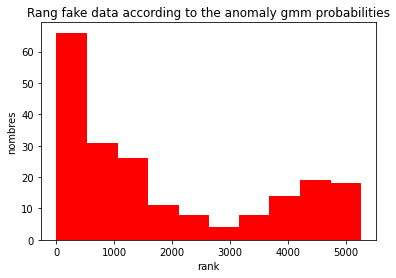

In [29]:
import matplotlib.pyplot as plt
import numpy as np
x=df_gmm[df_gmm['Customer_id'].isin(fake['Customer_id'].tolist())]['rank'].tolist()
print(np.max(x))
plt.hist(x, range = (0, np.max(x)), bins = 10, color = 'red',
            edgecolor = 'red')
plt.xlabel('rank')
plt.ylabel('nombres')
plt.title("Rang fake data according to the anomaly gmm probabilities")

In [28]:
test_gmm=df_gmm.head(1500)
anomalies_in_test3=test_gmm[test_gmm['Customer_id'].isin(fake['Customer_id'].tolist())]['Customer_id']
print(len(anomalies_in_test3))

120
